# Complete RaTag Analysis Pipeline - OPTIMIZED VERSION

This notebook demonstrates the **optimized unified pipeline** with ~50% time savings.

## Key Improvements

1. **Unified Integration**: X-ray classification + S2 integration in SINGLE pass (2 hours instead of 4)
2. **Fast S2 Window Estimation**: Uses only 2k waveforms instead of all 100k (~5 min instead of 30 min)
3. **Same Output**: Identical results to original pipeline, fully compatible

## Workflow

1. **Prepare Run**: Load data, estimate S1 times, compute fields (with fast S2 window estimation)
2. **Unified Integration**: X-ray classification + S2 integration in one pass ⚡
3. **S2 Fitting**: Fast post-processing (no waveform loading)
4. **Calibration**: Energy calibration and recombination analysis

**Total Time**: ~2.1 hours (vs ~4.5 hours for separate workflows)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from RaTag.datatypes import Run
from RaTag.config import IntegrationConfig, FitConfig
from RaTag.pipeline_optimized import (
    prepare_run_optimized,
    run_unified_integration,
    run_s2_fitting,
    run_calibration_analysis_optimized
)
import RaTag.plotting as plotting

%matplotlib inline

## 1. Define Run Parameters

In [192]:
# Set data directory
base_dir = Path('/Volumes/KINGSTON/RaTag_data/RUN14_Th228_rep')

# Define run parameters
run13 = Run(
    root_directory = base_dir,
    run_id = "RUN13",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 5e9,        # Hz (5 GS/s for FastFrame)
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm
    width_s2 = 20,              # µs
    
    # Calibration constants
    W_value = 22.0,             # eV per e-ion pair (Xe @ 2 bar)
    E_gamma_xray = 12.3e3,      # eV (Th-228 X-ray energy)
)

## 2. Prepare Run (OPTIMIZED)

**Key optimization**: S2 window estimation uses only **500 waveforms** instead of all ~100k

This step:
- Computes gas density from pressure/temperature
- Loads all measurement sets from directory structure
- Estimates S1 time for each set
- **Estimates S2 timing windows from 500 waveforms per set** (fast!)
- Computes drift/EL fields and transport properties

**Time**: ~1 minutes (vs ~30 minutes in old pipeline)

In [194]:
# Prepare run with optimized S2 window estimation
run13 = prepare_run_optimized(
    run13,
    flag_plot=False,
    max_frames_s1=200,
    threshold_s1=1.2,
    estimate_s2_windows=True,
    max_frames_s2=200,        # Only 500 frames needed for S2 window estimation
    s2_duration_cuts=(0, 35),
    threshold_s2=0.8
)

PREPARING RUN (OPTIMIZED): RUN13

[1/4] Gas density: 4.877e+19 cm⁻³
  Loaded: FieldScan_Gate0100_Anode2000 - 200 files (9600 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0200_Anode2100 - 200 files (9600 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0800_Anode2700 - 198 files (9504 waveforms) [FastFrame (48 frames/file)]

[2/4] Loaded 3 sets (all files)

[3/4] Preparing sets (using ~200 frames for S1 estimation)...

  Set 1/3: FieldScan_Gate0100_Anode2000
  S1 estimation: processing 5 files (~240 frames)
  → t_s1 = -3.445 ± 4.108 µs (from 78 frames)

  Set 2/3: FieldScan_Gate0200_Anode2100
  S1 estimation: processing 5 files (~240 frames)
  → t_s1 = -3.391 ± 3.656 µs (from 58 frames)

  Set 3/3: FieldScan_Gate0800_Anode2700
  S1 estimation: processing 5 files (~240 frames)
  → t_s1 = -3.411 ± 2.784 µs (from 34 frames)

[4/4] Estimating S2 timing windows (using ~200 frames per set)...

Set (0/3)
✓ FieldScan_Gate0100_Anode2000:
  Expected S2 start : 11

In [178]:
# Inspect prepared sets
print(f"Prepared {len(run13.sets)} sets:\n")
for i, s in enumerate(run13.sets):
    print(f"Set {i+1}: {s.source_dir.name}")
    print(f"  t_s1: ({s.metadata['t_s1']:.3f} ± {s.metadata['t_s1_std']:.3f}) µs")
    print(f"  Drift field: {s.drift_field:.1f} V/cm")
    print(f"  Drift time: {s.time_drift:.3f} µs")
    
    # Show S2 window if estimated
    if 't_s2_start' in s.metadata:
        print(f"  S2 window: [{s.metadata['t_s2_start']:.2f}, {s.metadata['t_s2_end']:.2f}] µs")
        print(f"  S2 duration: {s.metadata['s2_duration']:.2f} ± {s.metadata['s2_duration_std']:.2f} µs")
    print()

Prepared 5 sets:

Set 1: FieldScan_Gate0050_Anode1950
  t_s1: (-3.327 ± 3.595) µs
  Drift field: 35.7 V/cm
  Drift time: 19.976 µs
  S2 window: [18.01, 31.46] µs
  S2 duration: 0.01 ± 5.24 µs

Set 2: FieldScan_Gate0100_Anode2000
  t_s1: (-3.281 ± 2.959) µs
  Drift field: 71.4 V/cm
  Drift time: 15.138 µs
  S2 window: [9.39, 29.89] µs
  S2 duration: 1.49 ± 3.67 µs

Set 3: FieldScan_Gate0200_Anode2100
  t_s1: (-3.472 ± 3.551) µs
  Drift field: 142.9 V/cm
  Drift time: 13.210 µs
  S2 window: [7.75, 16.04] µs
  S2 duration: 1.54 ± 2.64 µs

Set 4: FieldScan_Gate0400_Anode2300
  t_s1: (-3.408 ± 3.044) µs
  Drift field: 285.7 V/cm
  Drift time: 11.835 µs

Set 5: FieldScan_Gate0600_Anode2500
  t_s1: (-3.412 ± 4.268) µs
  Drift field: 428.6 V/cm
  Drift time: 10.905 µs
  S2 window: [2.42, 23.45] µs
  S2 duration: 1.10 ± 1.54 µs



# Plot S2 distributions

  S2 estimation: processing 105 files (~5000 frames)


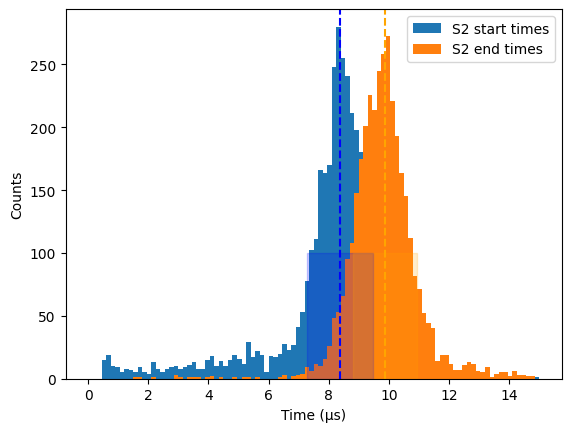

In [203]:
from RaTag.constructors import estimate_s2_window, compute_s2_variance

set = run13.sets[1]
t_start, t_end, duration = estimate_s2_window(set, max_frames=5000)

s2_start, s2_start_std = compute_s2_variance(t_start)
s2_end, s2_end_std = compute_s2_variance(t_end)
n,bins, _ = plt.hist(t_start, bins=100, range=(0,15), label='S2 start times')
plt.hist(t_end, bins=100,range=(0,15),  label='S2 end times');
plt.axvline(s2_start, ls='--', color='b')
plt.axvline(s2_end, ls='--', color='orange')

plt.fill_betweenx([0, 100], s2_start - s2_start_std, s2_start + s2_start_std, color='b', alpha=0.2)
plt.fill_betweenx([0, 100], s2_end - s2_end_std, s2_end + s2_end_std, color='orange', alpha=0.2)
plt.gca().set(xlabel='Time (µs)', ylabel='Counts')
plt.legend();


In [196]:
t_s1 = set.metadata['t_s1']
t_drift = set.time_drift
s2_start - t_s1, t_drift

(np.float64(4.9541999999999975), np.float64(10.208011631201))

In [164]:
t_s1 = pset.metadata['t_s1']
t_drift = pset.time_drift

In [202]:
500/1.4

357.14285714285717

In [166]:
s2_start - t_s1, t_drift

(np.float64(10.548475999999999), np.float64(13.209800817948338))

In [ ]:
t_drift_measured = 10.5  # µs
l_drift = 1.4         # cm
v_measured = l_drift / t_drift_measured  # cm/µs
v_measured * 10 

1.3333333333333333

## For 100 V

In [167]:
from RaTag.constructors import estimate_s2_window, compute_s2_variance

pset = run13.sets[0]
t_start, t_end, duration = estimate_s2_window(pset)

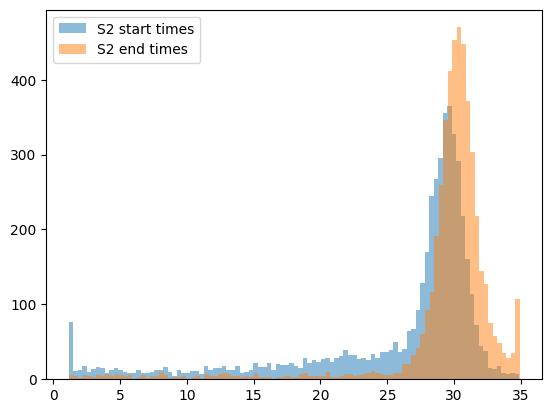

In [175]:
plt.hist(t_start, bins=100, alpha=0.5, label='S2 start times')
plt.hist(t_end, bins=100, alpha=0.5, label='S2 end times');
plt.legend();

In [169]:
t_end

array([32.5706, 31.186 , 30.4778, ..., 30.7106, 34.735 , 28.5902])

In [170]:
s2_start, s2_start_std = compute_s2_variance(t_start)
s2_end, s2_end_std = compute_s2_variance(t_end)
s2_start = s2_start - s2_start_std
s2_end = s2_end + s2_end_std
s2_start, s2_end

(np.float64(22.950304), np.float64(31.759079999999997))

In [171]:
t_s1 = pset.metadata['t_s1']
t_drift = pset.time_drift

In [172]:
s2_start - t_s1, t_drift

(np.float64(26.338304), np.float64(15.137548167034852))

### Optional: Manual Adjustment of S1 Times

If automatic S1 estimation is off for some sets, adjust manually:

In [ ]:
# low_end7 = run8.sets[7].metadata['t_s2_start_mean'] - run8.sets[7].metadata['t_s2_start_std']
# low_end8 = run8.sets[8].metadata['t_s2_start_mean'] - run8.sets[8].metadata['t_s2_start_std']

In [ ]:
# # Example: adjust S1 time for specific sets if needed
from dataclasses import replace

# run13.sets[0] = replace(run13.sets[0], metadata={**run13.sets[0].metadata, 't_s2_start': 12.2})
# run13.sets[0] = replace(run13.sets[0], metadata={**run13.sets[0].metadata, 't_s2_end': 16.80})

run13.sets[1] = replace(run13.sets[1], metadata={**run13.sets[1].metadata, 't_s2_start': 5.0})
run13.sets[1] = replace(run13.sets[1], metadata={**run13.sets[1].metadata, 't_s2_start_std': 0.5})


# run13.sets[0] = replace(run13.sets[0], metadata={**run13.sets[0].metadata, 't_s2_end': 12.50})
# run13.sets[0] = replace(run13.sets[0], metadata={**run13.sets[0].metadata, 't_s2_end_std': 1.250})

run13.sets[1] = replace(run13.sets[1], metadata={**run13.sets[1].metadata, 't_s2_end': 10.50})
run13.sets[1] = replace(run13.sets[1], metadata={**run13.sets[1].metadata, 't_s2_end_std': 0.5})

### Visualize S2 Windows

Check that S2 integration windows are correctly positioned:

In [41]:
j = 0

34

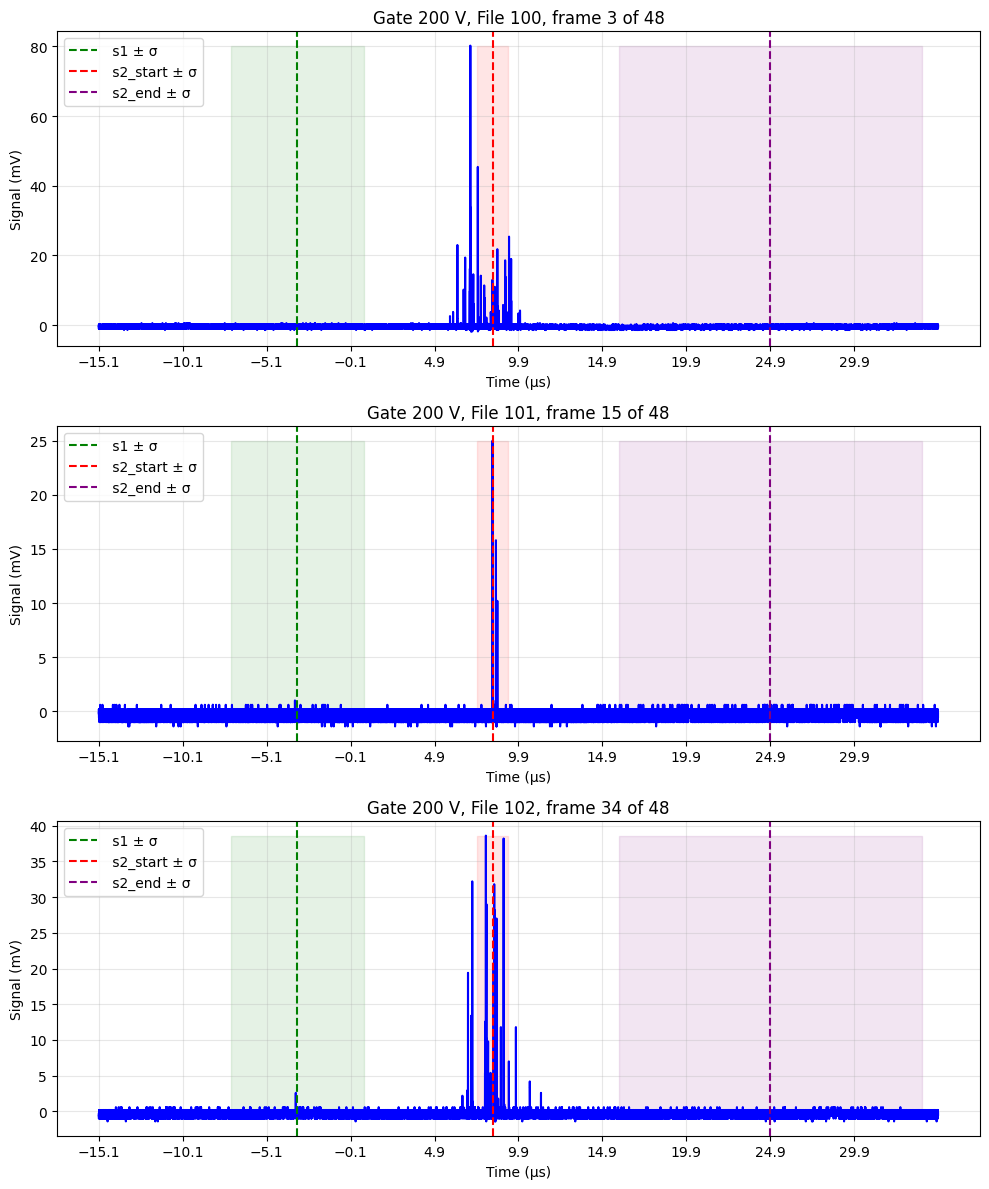

In [158]:

pset = run13.sets[1]
j += 1
fig, ax = plt.subplots(3, figsize=(10, 4*3))
plotting.plot_set_windows(pset, ax=ax[0], file_index=0, frame=3)
plotting.plot_set_windows(pset, ax=ax[1], file_index=1, frame=15)
plotting.plot_set_windows(pset, ax=ax[2], file_index=2, frame=j)
j

['RUN13_20251026_Gate100_Anode2000_P1_1042Wfm.wfm'
 'RUN13_20251026_Gate100_Anode2000_P1_1153Wfm.wfm'
 'RUN13_20251026_Gate100_Anode2000_P1_1249Wfm.wfm']
['RUN13_20251026_Gate200_Anode2100_P3_463Wfm.wfm'
 'RUN13_20251026_Gate200_Anode2100_P3_1195Wfm.wfm'
 'RUN13_20251026_Gate200_Anode2100_P3_1107Wfm.wfm']


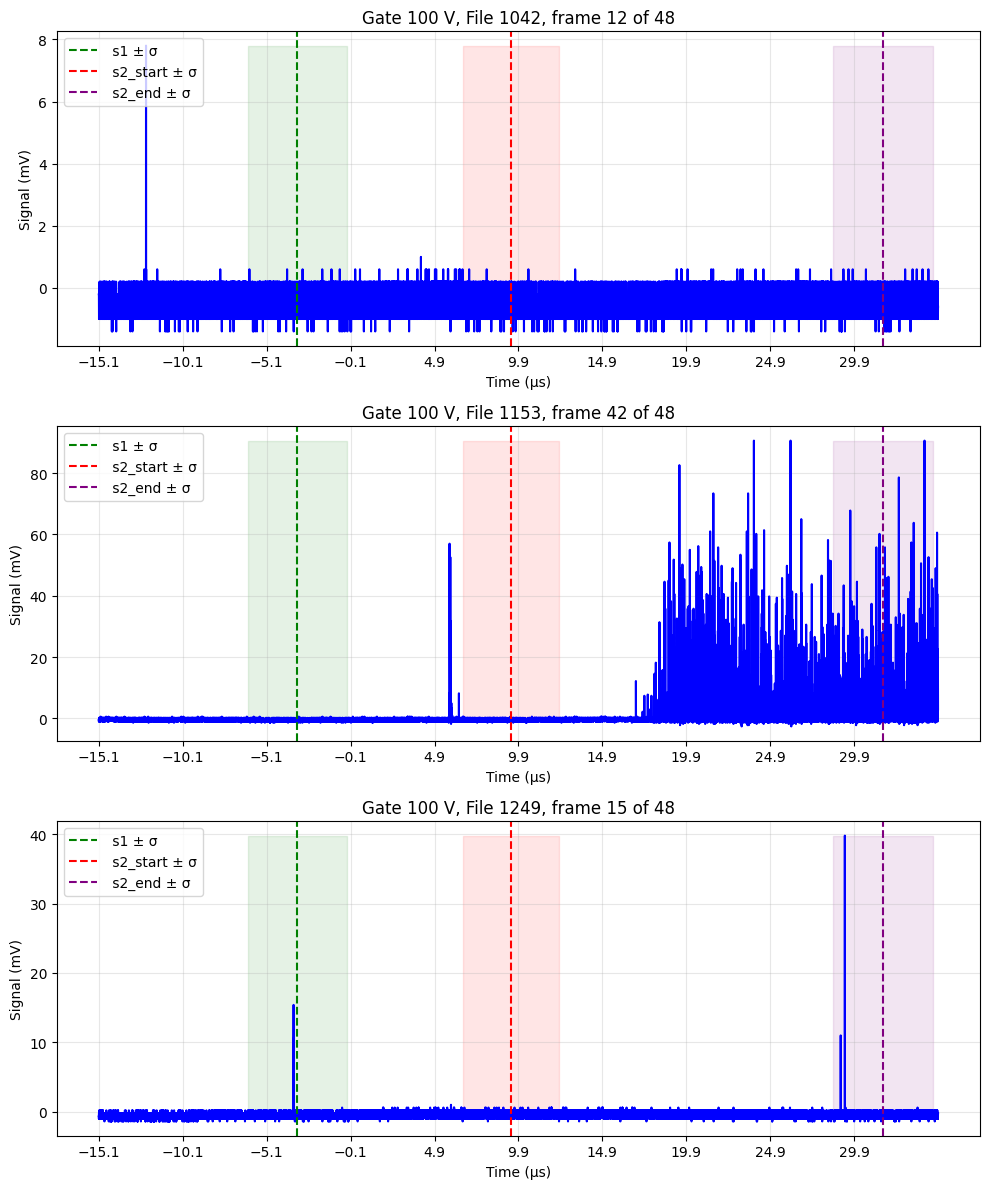

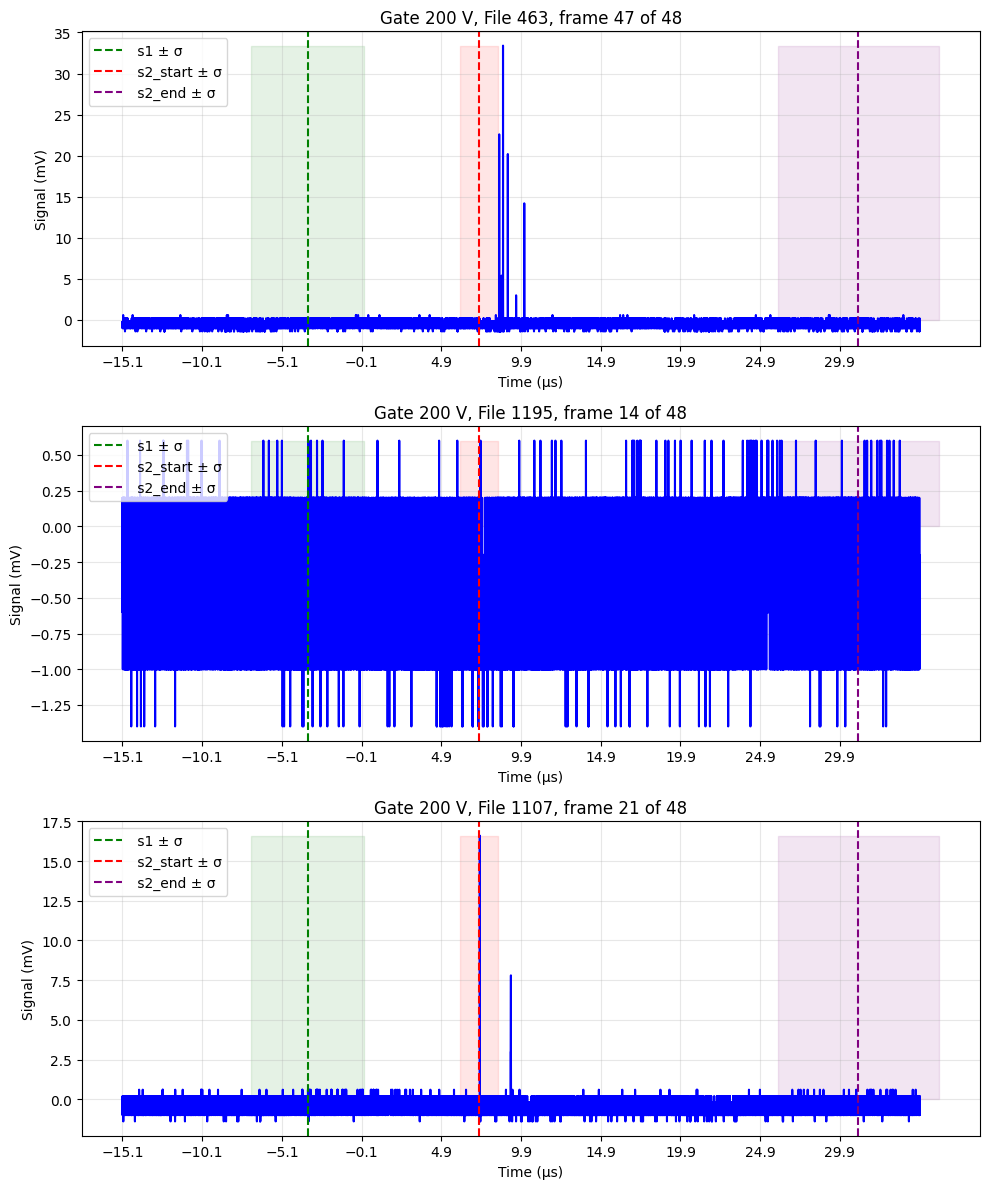

In [32]:
# Plot S2 windows for visual verification
for s in run13.sets[1:3]:
    plotting.plot_n_waveforms(s, n_waveforms=3)

## 3. Unified Integration (MAJOR OPTIMIZATION)

**This is the key optimization!** 

Instead of running X-ray classification and S2 integration separately (each taking ~2 hours), we process both **in a single pass** over all waveforms.

**What happens here**:
1. Load each waveform once
2. Preprocess once (unit conversion, pedestal subtraction, moving average, threshold clip)
3. Extract X-ray window → classify
4. Extract S2 window → integrate
5. Save both results

**Time**: ~2 hours (vs ~4 hours for separate workflows)  
**Speedup**: 2× faster!

### Testing Mode

For quick testing, uncomment the `nfiles=10` parameter below to process only 20 files per set (~1 minutes total).

In [132]:
# Define integration configurations
xray_config = IntegrationConfig(
    bs_threshold = 0.5,        # mV
    n_pedestal = 200,          # samples
    ma_window = 10,            # samples
    dt = 2e-4,                 # µs
)

ion_config = IntegrationConfig(
    bs_threshold = 0.8,        # mV
    n_pedestal = 2000,         # samples
    ma_window = 9,             # samples
    dt = 2e-4,                 # µs
)

In [ ]:
# UNIFIED INTEGRATION: X-ray classification + S2 integration in SINGLE PASS
xray_results, s2_areas = run_unified_integration(
    run13,
    ts2_tol=-0.2,
    xray_config=xray_config,
    ion_config=ion_config,
    use_estimated_s2_windows=True,
    max_frames=None  # Set to 10 for testing, None for full run
)

print("\n✓ Unified integration complete!")
print(f"✓ Processed {len(s2_areas)} sets in SINGLE pass")
print("✓ X-ray results saved: xray_results.json, xray_areas.npy")
print("✓ S2 results saved: s2_areas.npy, s2_results.json")

Production mode: processing ALL files (400 files, 19200 frames)
UNIFIED INTEGRATION: X-RAY CLASSIFICATION + S2 AREAS
Processing 2 sets with SINGLE pass over waveforms

[1/2] Processing: FieldScan_Gate0100_Anode2000
  → Using tS1: [-3.39 ± 4.09] µs
  → Using estimated S2 window: [8.00, 12.50] µs
  → X-rays: 518/9600 accepted (5.4%)
  → S2 areas: 9600 integrated
  → Saved: xray_results.json, xray_areas.npy, s2_areas.npy, s2_results.json

[2/2] Processing: FieldScan_Gate0200_Anode2100
  → Using tS1: [-3.28 ± 3.95] µs
  → Using estimated S2 window: [2.30, 10.50] µs
  → X-rays: 908/9600 accepted (9.5%)
  → S2 areas: 9600 integrated
  → Saved: xray_results.json, xray_areas.npy, s2_areas.npy, s2_results.json

UNIFIED INTEGRATION COMPLETE
✓ Processed 2 sets in SINGLE pass
✓ X-ray results saved for calibration workflow
✓ S2 areas saved for fitting workflow


✓ Unified integration complete!
✓ Processed 2 sets in SINGLE pass
✓ X-ray results saved: xray_results.json, xray_areas.npy
✓ S2 results sa

In [16]:
# # UNIFIED INTEGRATION: X-ray classification + S2 integration in SINGLE PASS
# xray_results_hv, s2_areas_hv = run_unified_integration(
#     run8,
#     range_sets= slice(7, 9),
#     ts2_tol=-2.7,
#     xray_config=xray_config,
#     ion_config=ion_config,
#     use_estimated_s2_windows=True,
#     max_frames=None  # Set to 10 for testing, None for full run
# )

# print("\n✓ Unified integration complete!")
# print(f"✓ Processed {len(s2_areas_hv)} sets in SINGLE pass")
# print("✓ X-ray results saved: xray_results.json, xray_areas.npy")
# print("✓ S2 results saved: s2_areas.npy, s2_results.json")

### Check Results

Verify that both X-ray and S2 data were collected:

In [134]:
# Check X-ray classification results
print("X-ray Classification Summary:\n")
for set_name, xray_result in xray_results.items():
    n_accepted = sum(1 for e in xray_result.events if e.accepted)
    n_total = len(xray_result.events)
    print(f"{set_name}:")
    print(f"  {n_accepted}/{n_total} events accepted ({100*n_accepted/n_total:.1f}%)")

X-ray Classification Summary:

FieldScan_Gate0100_Anode2000:
  518/9600 events accepted (5.4%)
FieldScan_Gate0200_Anode2100:
  908/9600 events accepted (9.5%)


In [261]:
s2_areas = {**s2_areas, **s2_areas_hv}

In [135]:
# Check S2 integration results
print("\nS2 Integration Summary:\n")
for set_name, s2_result in s2_areas.items():
    n_areas = len(s2_result.areas)
    valid_areas = s2_result.areas[~np.isnan(s2_result.areas)]
    print(f"{set_name}:")
    print(f"  {len(valid_areas)}/{n_areas} valid S2 areas")
    print(f"  Mean: {np.mean(valid_areas):.3f} mV·µs")
    print(f"  Std: {np.std(valid_areas):.3f} mV·µs")


S2 Integration Summary:

FieldScan_Gate0100_Anode2000:
  9600/9600 valid S2 areas
  Mean: 0.090 mV·µs
  Std: 1.312 mV·µs
FieldScan_Gate0200_Anode2100:
  9600/9600 valid S2 areas
  Mean: 1.135 mV·µs
  Std: 7.530 mV·µs


## 4. S2 Fitting (Fast Post-Processing)

Fit Gaussian distributions to the S2 area histograms.

**This is fast** (~1 minute) because it only fits already-integrated data, no waveform loading.

In [263]:
from RaTag.dataIO import load_s2area
s2_areas = {}
for set in run8.sets:
    s2_areas[set.source_dir.name] = load_s2area(set)

In [26]:
[s.source_dir.name for s in run13.sets]

['FieldScan_Gate0050_Anode1950',
 'FieldScan_Gate0100_Anode2000',
 'FieldScan_Gate0200_Anode2100',
 'FieldScan_Gate0400_Anode2300',
 'FieldScan_Gate0600_Anode2500']

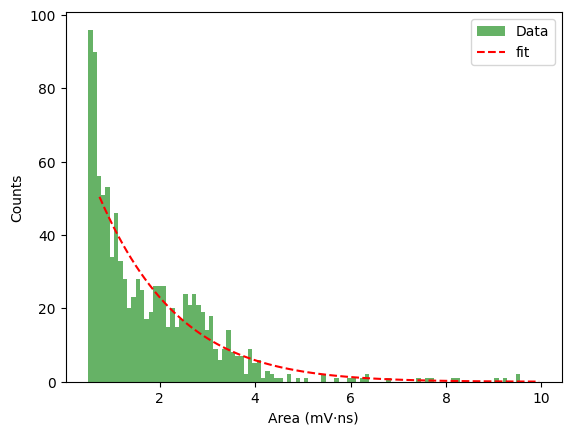

In [136]:
from RaTag.analysis import fit_set_s2

s2_50 = fit_set_s2(s2_areas[run13.sets[1].source_dir.name],
    nbins=100,
    bin_cuts=(0.5, 10),
    exclude_index=2,
    flag_plot=True
)

In [290]:
s2_50.mean, s2_50.ci95

(np.float64(-0.02396100803358308), np.float64(0.04466305309713697))

In [18]:
# Define fitting configuration
fit_config = FitConfig(
    bin_cuts = (0, 6),        # mV·µs
    nbins = 100,
    exclude_index = 2,         # Skip first 2 bins (pedestal)
)

FITTING S2 DISTRIBUTIONS

S2 FITTING COMPLETE

✓ S2 fitting complete!
✓ Plots saved to plots/ directory


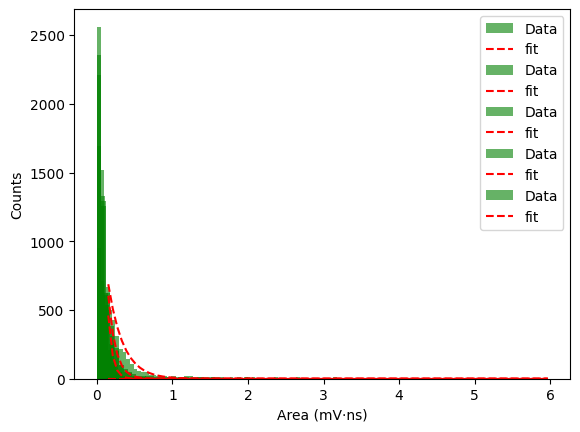

In [19]:
# Fit S2 distributions
s2_fitted = run_s2_fitting(
    run13,
    s2_areas,
    fit_config=fit_config,
    flag_plot=True,      # Set to True to display plots interactively
    save_plots=False       # Save plots to disk
)

print("\n✓ S2 fitting complete!")
print("✓ Plots saved to plots/ directory")

### Visualize S2 Fits

In [21]:
# Display fit results
print("S2 Gaussian Fit Results:\n")
for set_name, fit in s2_fitted.items():
    if fit.fit_success:
        print(f"{set_name}:")
        print(f"  Mean: {fit.mean:.3f} ± {fit.ci95:.3f} mV·µs")
        print(f"  Sigma: {fit.sigma:.3f} mV·µs")
    else:
        print(f"{set_name}: Fit failed")

S2 Gaussian Fit Results:

FieldScan_Gate0050_Anode1950: Fit failed
FieldScan_Gate0100_Anode2000: Fit failed
FieldScan_Gate0200_Anode2100: Fit failed
FieldScan_Gate0400_Anode2300: Fit failed
FieldScan_Gate0600_Anode2500: Fit failed


ValueError: 'yerr' must not contain None. Use NaN if you want to skip a value.

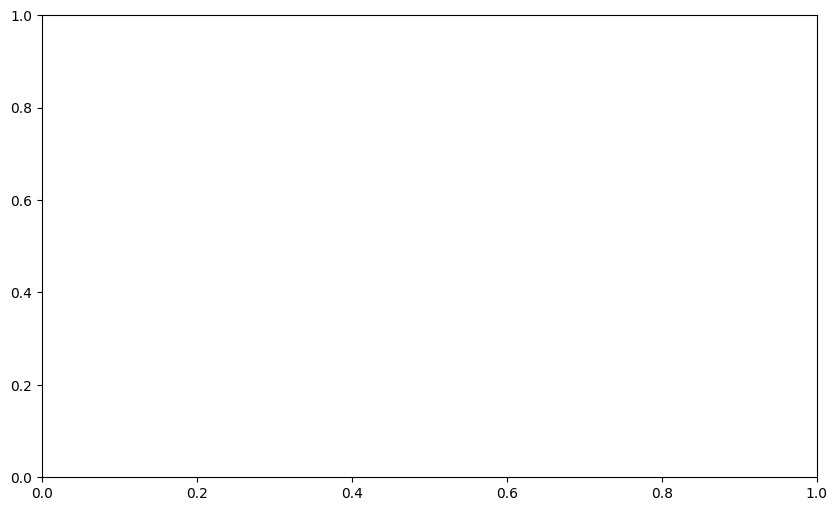

In [20]:
# Plot S2 vs drift field
fig, ax = plotting.plot_s2_vs_drift(run13, s2_fitted, normalized=False)
plt.show()

In [268]:
import pandas as pd
result_run8 = pd.DataFrame.from_dict({
    s.source_dir.name: {
        'drift_field_V_per_cm': s.drift_field,
        's2_mean_mV_us': s2_fitted[s.source_dir.name].mean,
        's2_ci95_mV_us': s2_fitted[s.source_dir.name].ci95
    }
    for s in run8.sets
}, orient='index')

result_run8.to_csv('/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/run8_s2_drift_results.csv')

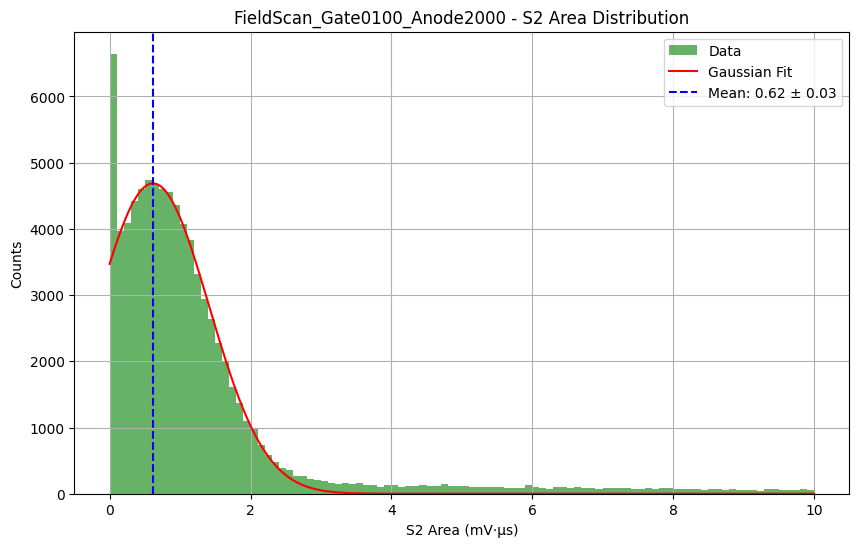

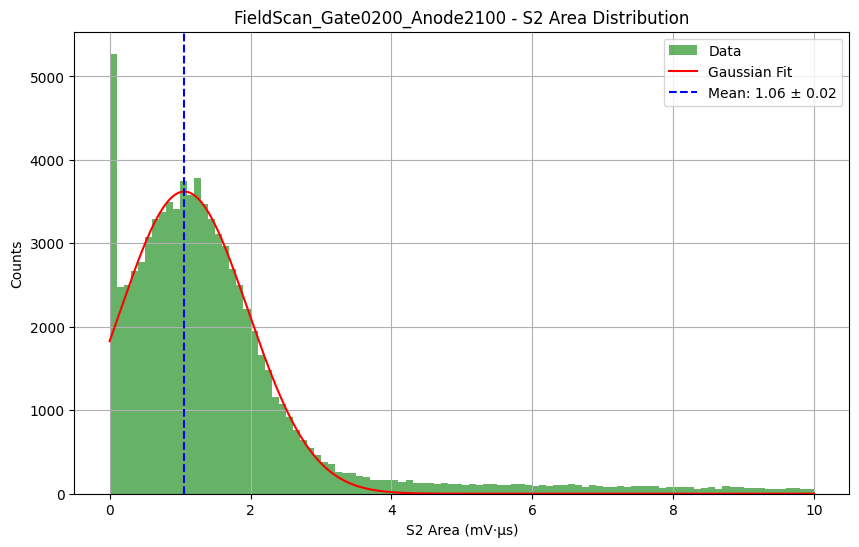

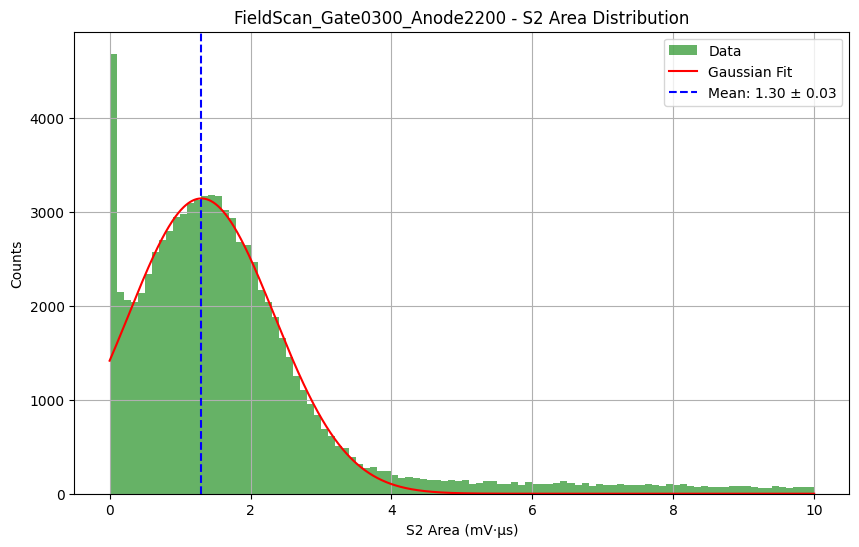

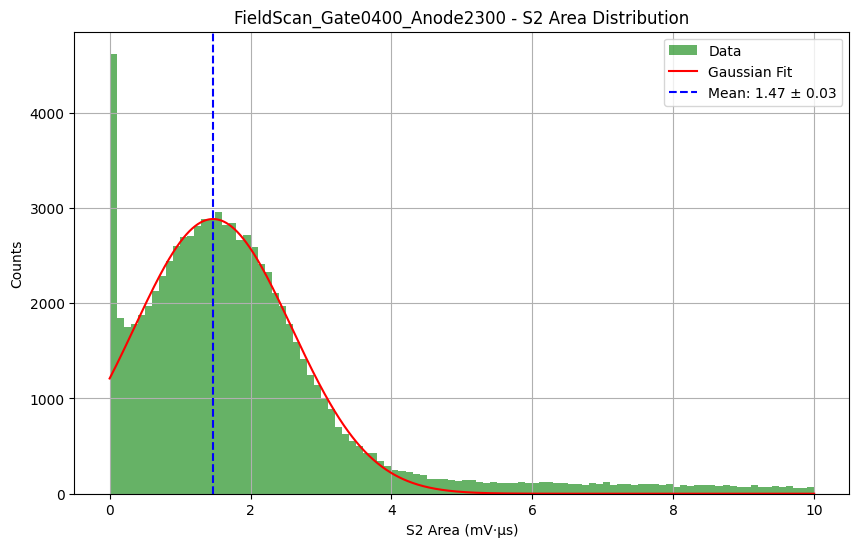

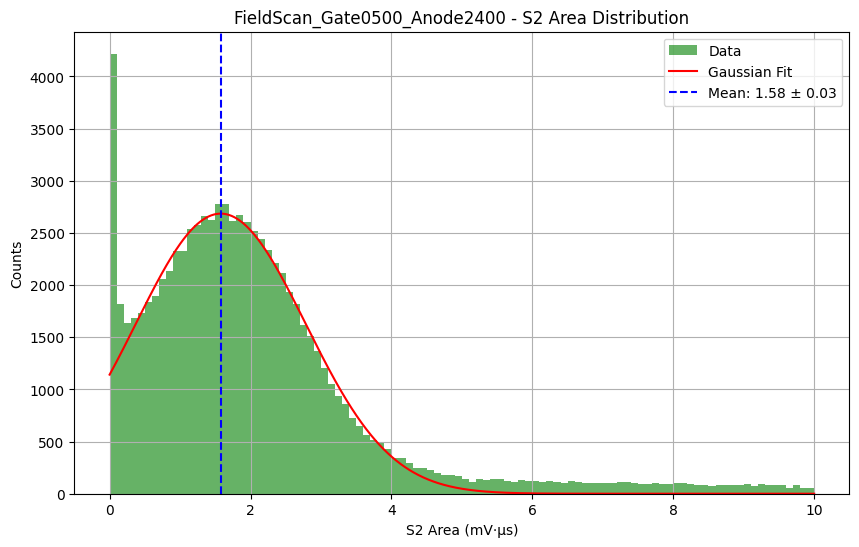

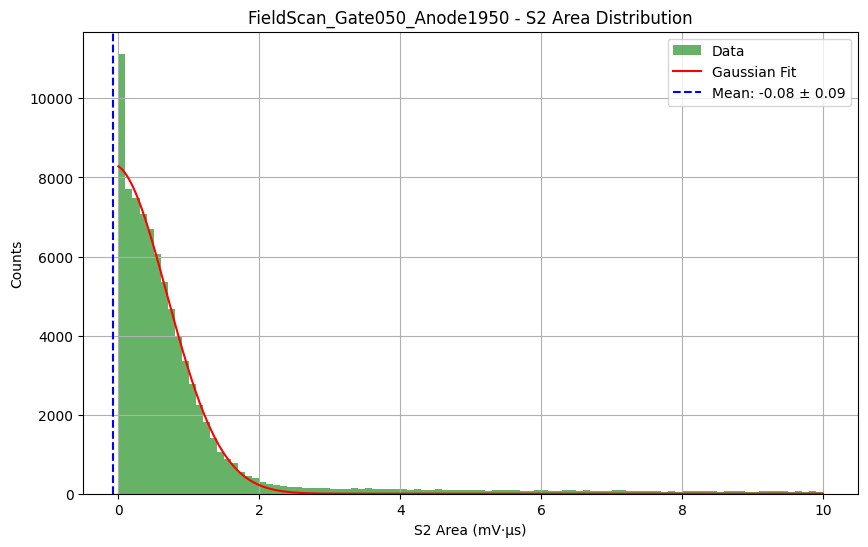

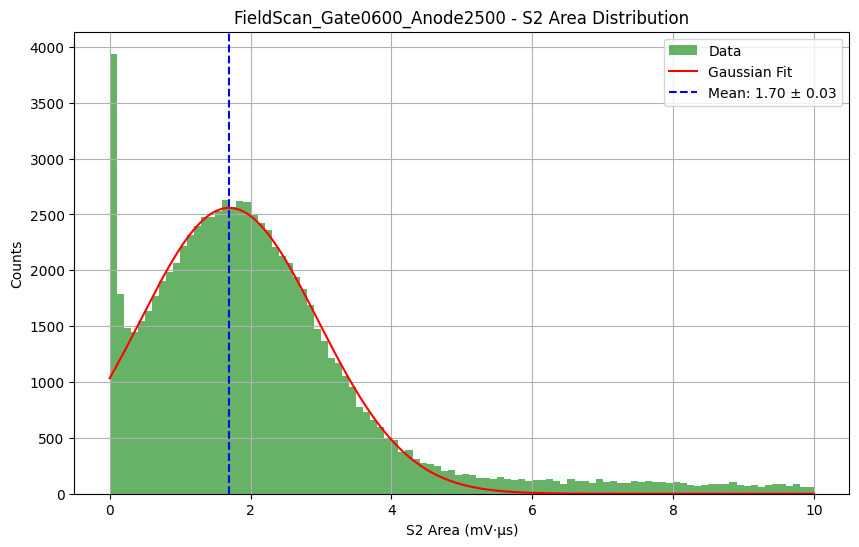

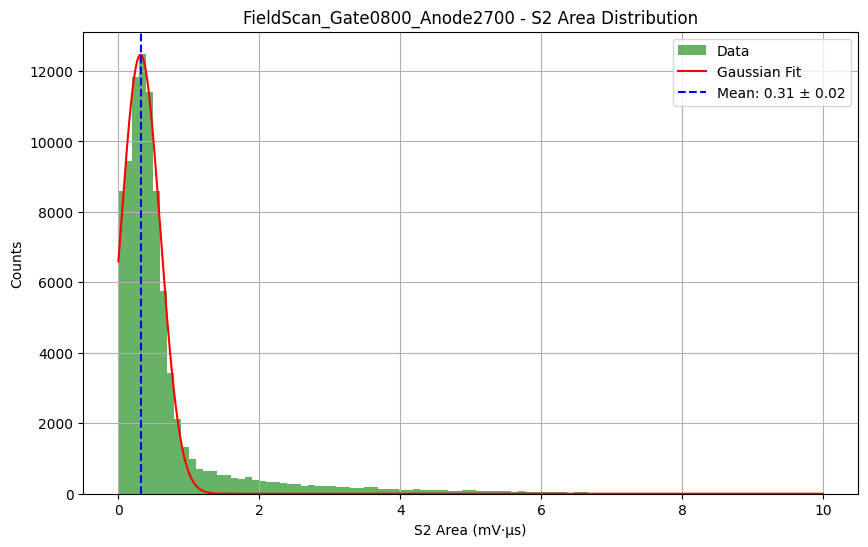

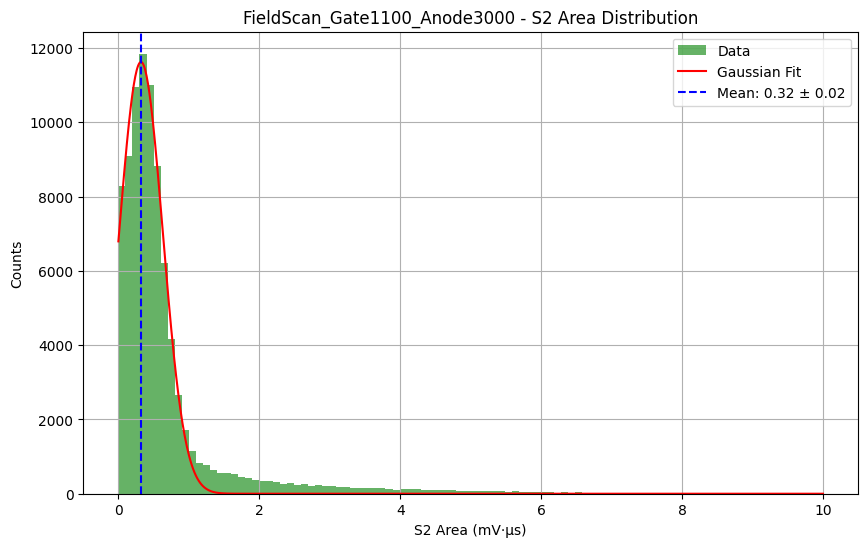

In [223]:
# Show individual histograms with fits
for set_name, fit in list(s2_fitted.items())[:]:  # Show first 3 sets
    fig, ax = plotting.plot_hist_fit(fit, nbins=fit_config.nbins, bin_cuts=fit_config.bin_cuts)
    plt.title(f"{set_name} - S2 Area Distribution")
    plt.show()

## 5. Calibration and Recombination Analysis

Use X-ray data (saved during unified integration) to calibrate the energy scale and compute electron recombination fractions.

**This step loads X-ray data from disk** (saved in step 3).

**Time**: ~1 minute

In [94]:
from RaTag.dataIO import load_xray_results


xray_res = load_xray_results(run8)

In [102]:
xray_res['FieldScan_Gate050_Anode1950']

XRayResults(set_id=PosixPath('/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate050_Anode1950'), events=[0.008939125292715814, 0.002237117358344299, 0.012918768954397005, 0.021975205975416207, 0.00827787836591242, 0.018119594742514088, 0.013796015896488989, 0.0069006638084324785, 0.0008532469403932505, 0.11519830435379483, 0.14561466456668032, 0.015069396086619542, 0.0004678354197802952, 0.02700539693145578, 0.000580794274442247, 0.0010566296947887854, 0.014486684118708227, 0.0007667119809349288, 0.007356529727365597, 0.04461350412443327, 0.12629456831919406, 0.0007739002481103878, 0.07077423479610315, 0.03589608919407686, 0.09368647935784352, 0.012345059287122937, 0.06051528272330262, 0.06015470193111386, 0.010359588413256952, 0.24730783899790848, 0.10689535137277423, 0.006018323492646678, 0.0019498247446762538, 0.012588994244388769, 0.0005462402719964953, 0.0003133441621786579, 0.06655584844419027, 0.04074502865728727, 0.0005702402736952276, 0.0005432833051205332, 0.19

In [91]:
from RaTag.datatypes import XRayResults


xray_res_path = '/Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/FieldScan_Gate100_Anode2000/xray_areas.npy'
events = np.load(xray_res_path, allow_pickle=True)
XRayResults(set_id=run8.sets[0].source_dir.name, events=events, params={})

XRayResults(set_id='FieldScan_Gate050_Anode1950', events=array([0.04116077, 0.16350036, 0.04676835, ..., 0.00042427, 0.04077069,
       0.09748516]), params={})


CALIBRATION & RECOMBINATION ANALYSIS
Loading X-ray data from disk (saved by unified integration)...
CALIBRATION AND RECOMBINATION ANALYSIS

[1/5] Loading X-ray results...
  → FieldScan_Gate050_Anode1950: 15513 accepted events
  → FieldScan_Gate100_Anode2000: 11398 accepted events
  → FieldScan_Gate200_Anode2100: 10831 accepted events
  → FieldScan_Gate300_Anode2200: 11125 accepted events
  → FieldScan_Gate400_Anode2300: 10087 accepted events
  → FieldScan_Gate500_Anode2400: 10026 accepted events
  → FieldScan_Gate600_Anode2500: 9849 accepted events
  → Total: 78829 accepted X-ray events

[2/5] Fitting X-ray histogram...


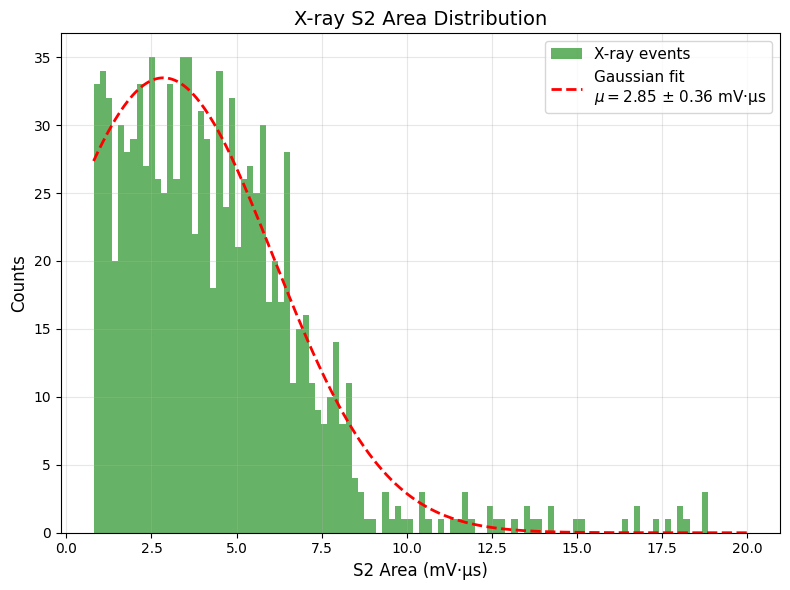

  → X-ray mean: 2.851 ± 0.357 mV·µs
  → X-ray sigma: 3.228 mV·µs
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/RUN8_xray_histogram.png

[3/5] Computing calibration constants...
  → Expected electrons (N_e_exp): 559.1
  → Gain factor (g_S2): 0.0051 mV·µs/electron

[4/5] Using provided ion fitted areas (7 sets)

[5/5] Computing recombination fractions...
  → Recombination fractions computed for 7 field points
  → r range: [0.390, 1.046]


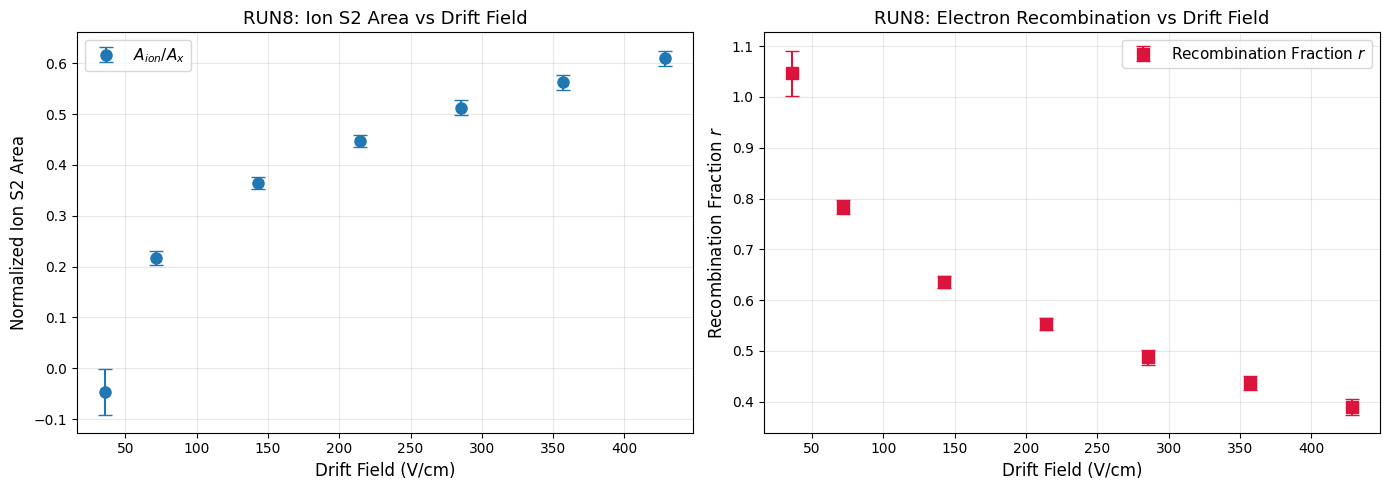


CALIBRATION COMPLETE

Generating and saving comprehensive plots...
  → S2 vs drift (normalized)...
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/RUN8_s2_vs_drift_normalized.png
  → Diffusion analysis...
  → Saved: /Volumes/KINGSTON/RaTag_data/RUN8_EL2350Vcm_5GSsec/plots/RUN8_diffusion_analysis.png

CALIBRATION ANALYSIS COMPLETE

✓ Calibration analysis complete!
✓ All plots saved to plots/ directory


In [113]:
# Run complete calibration analysis
calib_results, recomb_results = run_calibration_analysis_optimized(
    run8,
    ion_fitted_areas=s2_fitted,
    xray_bin_cuts=(0.8, 20),
    xray_nbins=100,
    flag_plot=True,
    save_plots=True
)

print("\n✓ Calibration analysis complete!")
print("✓ All plots saved to plots/ directory")

### Display Calibration Results

In [67]:
print("=" * 60)
print("CALIBRATION CONSTANTS")
print("=" * 60)
print(f"Run: {calib_results.run_id}")
print(f"X-ray mean area (A_x): {calib_results.A_x_mean:.3f} mV·µs")
print(f"Expected electrons (N_e_exp): {calib_results.N_e_exp:.1f}")
print(f"Gain factor (g_S2): {calib_results.g_S2:.4f} mV·µs/electron")
print()

CALIBRATION CONSTANTS
Run: RUN8
X-ray mean area (A_x): 4.391 mV·µs
Expected electrons (N_e_exp): 559.1
Gain factor (g_S2): 0.0079 mV·µs/electron



In [68]:
print("=" * 60)
print("RECOMBINATION vs DRIFT FIELD")
print("=" * 60)
for i, Ed in enumerate(recomb_results['drift_fields']):
    r = recomb_results['r'][i]
    dr = recomb_results['dr'][i]
    print(f"E_d = {Ed:6.1f} V/cm → r = {r:.3f} ± {dr:.3f}")

RECOMBINATION vs DRIFT FIELD
E_d =   35.7 V/cm → r = 1.030 ± 0.029
E_d =   71.4 V/cm → r = 0.859 ± 0.009
E_d =  142.9 V/cm → r = 0.763 ± 0.007
E_d =  214.3 V/cm → r = 0.710 ± 0.008
E_d =  285.7 V/cm → r = 0.667 ± 0.010
E_d =  357.1 V/cm → r = 0.635 ± 0.009
E_d =  428.6 V/cm → r = 0.604 ± 0.010


### Visualize Calibration Results

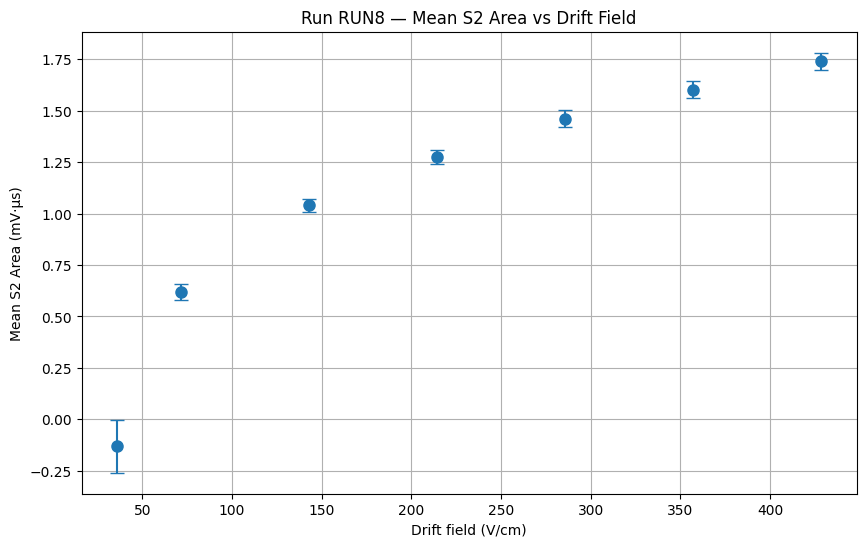

In [69]:
# Plot normalized S2 vs drift field (shows recombination)
fig, ax = plotting.plot_s2_vs_drift(run8, s2_fitted, normalized=True)
plt.show()

## 6. Time Comparison Summary

Let's review the time savings:

| Step | Old Pipeline | Optimized Pipeline | Speedup |
|------|-------------|-------------------|---------|
| Prepare run | ~30 min (all wfms) | ~5 min (2k wfms) | **6×** |
| X-ray classification | ~2 hours | - | - |
| S2 integration | ~2 hours | - | - |
| **Unified integration** | - | **~2 hours** | **2×** |
| S2 fitting | ~1 min | ~1 min | 1× |
| Calibration | ~1 min | ~1 min | 1× |
| **TOTAL** | **~4.5 hours** | **~2.1 hours** | **2.1×** |

**Key insight**: By processing each waveform only once for both X-ray and S2, we cut the processing time in half!

## 7. Export Results (Optional)

In [ ]:
# Package all results
results_dict = {
    'calibration': {
        'run_id': calib_results.run_id,
        'A_x_mean': calib_results.A_x_mean,
        'N_e_exp': calib_results.N_e_exp,
        'g_S2': calib_results.g_S2,
    },
    'recombination': {
        'drift_fields': recomb_results['drift_fields'],
        'recombination': recomb_results['recombination'],
        'recombination_uncertainty': recomb_results['recombination_uncertainty'],
    },
    's2_fits': {
        set_name: {
            'mean': fit.mean,
            'sigma': fit.sigma,
            'ci95': fit.ci95,
            'fit_success': fit.fit_success
        }
        for set_name, fit in s2_fitted.items()
    }
}

# Uncomment to save
# import pickle
# output_file = base_dir / f'{run8.run_id}_analysis_results_optimized.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(results_dict, f)
# print(f"✓ Results saved to {output_file}")

## Summary

This notebook demonstrated the **optimized unified pipeline** with significant performance improvements:

### ✅ Completed Steps

1. ✅ **Prepare Run** (~5 min) - Fast S2 window estimation with only 2k waveforms
2. ✅ **Unified Integration** (~2 hours) - X-ray + S2 in single pass
3. ✅ **S2 Fitting** (~1 min) - Fast post-processing
4. ✅ **Calibration** (~1 min) - Energy scale and recombination

### 🎯 Key Benefits

- **~50% faster** - 2.1 hours instead of 4.5 hours
- **Same results** - Identical output to original pipeline
- **Same files** - Fully compatible with existing tools
- **Less code** - Simpler workflow with unified integration

### 📁 Output Files

All results saved to run directory:
- Per-set: `xray_results.json`, `xray_areas.npy`, `s2_areas.npy`, `s2_results.json`
- Plots: `plots/{set_name}_s2_histogram.png`, `plots/{set_name}_waveform_validation.png`
- Run-level: `plots/{run_id}_s2_vs_drift.png`, `plots/{run_id}_xray_histogram.png`, etc.

### 🧪 Testing Tip

For quick testing, set `nfiles=10` in the integration step to process only 10 files per set (~2 minutes total).

---

**Documentation**: See `UNIFIED_INTEGRATION_OPTIMIZATION.md` for technical details.